# Capstone Project

## Import Libraries and set environment

In [1]:
import os

import pandas as pd
#import seaborn as sns #must be installed in SM
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# Set environment variables 
session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = "capstone520"
prefix = "data/"

## Explore data

In [18]:
# Import data
dataset = pd.read_csv("data/ecoli_structure_filtered.csv")
dataset.head()

,...1,bacterium,modifications,sequence,strain,unit,url_source,log(MIC),pMIC,is_modified,...,sequence_len,id,secondary_structure,len,helix_group,sheet_group,coil_group,helix_percentage,sheet_percentage,coil_percentage
0,2112,E. coli,[],AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,ATCC 25922,uM,https://dbaasp.org/peptide-card?id=5613,2.10,3.90,False,...,33,GRAMPA_1984,CCCHHHHHHHCCCHHHHHHHHHHHHHHHHHCCC,33,70-80,0-10,20-30,72.73,0.00,27.27
1,5527,E. coli,[C-Terminus: AMD],AAAAAAAIKMLMDLVNERIMALNKKAKK,ATCC 25922,uM,https://dbaasp.org/peptide-card?id=7719,1.00,5.00,True,...,28,GRAMPA_5154,CCCHHHHHHHHHHHHHHHHHHHHHHCCC,28,70-80,0-10,20-30,78.57,0.00,21.43
2,7671,E. coli,[],AAAAGSVWGAVNYTSDCNGECKRRGYKGGYCGSFANVNCWCET,NaN,uM,http://www.yadamp.unisa.it/showItem.aspx?yadam...,2.00,4.00,False,...,43,GRAMPA_5919,CCCCCCCECCCCECCCHHHHHHHCCCCEEEEECCCCCEEEEEC,43,10-20,20-30,50-60,16.28,27.91,55.81
3,3562,E. coli,[],AAAKAALNAVLVGANA,TG1,uM,https://dbaasp.org/peptide-card?id=618,1.90,4.10,False,...,16,GRAMPA_3326,CCCHHHHHHHHHCCCC,16,50-60,0-10,40-50,56.25,0.00,43.75
4,5678,E. coli,[],AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,NaN,uM,https://dbaasp.org/peptide-card?id=5171,0.25,5.75,False,...,40,GRAMPA_5298,CCCCCCCCCCCECCCCCCCCCCCCCCEEEECECHHCCCCC,40,0-10,10-20,70-80,5.00,15.00,80.00


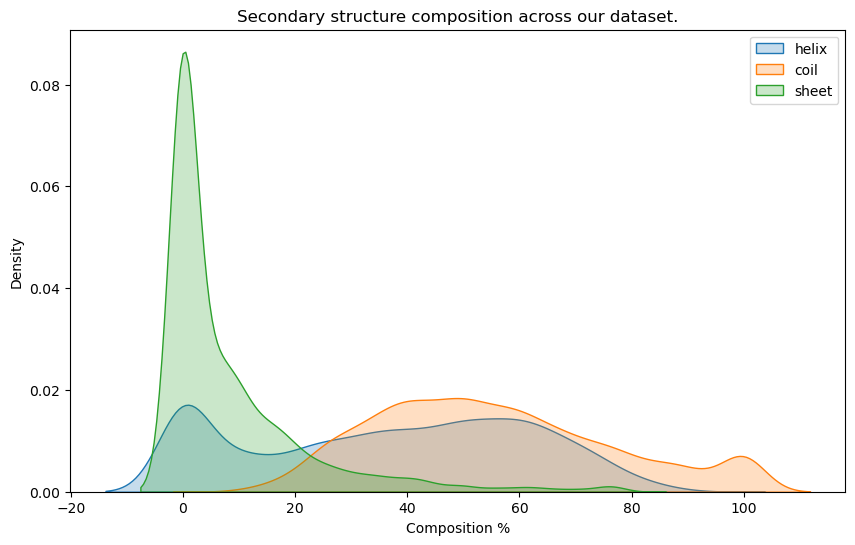

In [3]:
# Create figure and axis
plt.figure(figsize=(10, 6))

# Density plots for secondary structure composition 
sns.kdeplot(dataset["helix_percentage"], label="helix", fill=True) #kde: Kernel Density Estimate
sns.kdeplot(dataset["coil_percentage"], label="coil", fill=True)
sns.kdeplot(dataset["sheet_percentage"], label="sheet", fill=True)

# Customize the plot
plt.title("Secondary structure composition across our dataset.")
plt.xlabel("Composition %")
plt.legend()

# Show plot
plt.show()

In [5]:
dataset.columns

Index(['...1', 'bacterium', 'modifications', 'sequence', 'strain', 'unit',
       'url_source', 'log(MIC)', 'pMIC', 'is_modified',
       'has_unusual_modification', 'has_cterminal_amidation',
       'datasource_has_modifications', 'database', 'sequence_len', 'id',
       'secondary_structure', 'len', 'helix_group', 'sheet_group',
       'coil_group', 'helix_percentage', 'sheet_percentage',
       'coil_percentage'],
      dtype='object')

C:\Users\Momas\AppData\Local\Temp\ipykernel_17872\1674920667.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


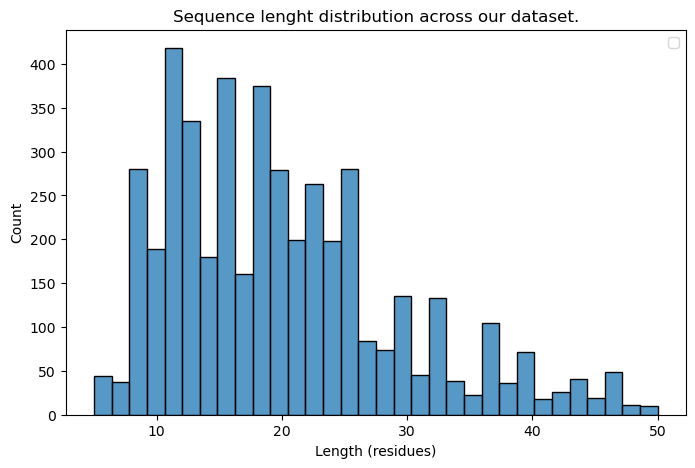

In [8]:
# Create figure and axis
plt.figure(figsize=(8, 5))

# Density plots for secondary structure composition 
sns.histplot(dataset["sequence_len"], kde=False)

# Customize the plot
plt.title("Sequence lenght distribution across our dataset.")
plt.xlabel("Length (residues)")
plt.legend()

# Show plot
plt.show()

In [5]:
dataset.shape

(4540, 24)

## Prepare data

Well limit the target values to 3 decimal digits. More than 3 are not significantly relevant for our regression task.

In [22]:
dataset.pMIC.head()

0    3.90
1    5.00
2    4.00
3    4.10
4    5.75
Name: pMIC, dtype: float64

In [25]:
# Max length of pMIC 
def max_precision(column):
    return max(column.apply(lambda x: len(str(x).split('.')[1]) if '.' in str(x) else 0))

max_precision(dataset.pMIC)

16

In [26]:
def round_column(df, column_name):
    df[column_name] = df[column_name].round(3)

round_column(dataset, "pMIC")

,...1,bacterium,modifications,sequence,strain,unit,url_source,log(MIC),pMIC,is_modified,...,sequence_len,id,secondary_structure,len,helix_group,sheet_group,coil_group,helix_percentage,sheet_percentage,coil_percentage
0,2112,E. coli,[],AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,ATCC 25922,uM,https://dbaasp.org/peptide-card?id=5613,2.10,3.900,False,...,33,GRAMPA_1984,CCCHHHHHHHCCCHHHHHHHHHHHHHHHHHCCC,33,70-80,0-10,20-30,72.73,0.00,27.27
1,5527,E. coli,[C-Terminus: AMD],AAAAAAAIKMLMDLVNERIMALNKKAKK,ATCC 25922,uM,https://dbaasp.org/peptide-card?id=7719,1.00,5.000,True,...,28,GRAMPA_5154,CCCHHHHHHHHHHHHHHHHHHHHHHCCC,28,70-80,0-10,20-30,78.57,0.00,21.43
2,7671,E. coli,[],AAAAGSVWGAVNYTSDCNGECKRRGYKGGYCGSFANVNCWCET,NaN,uM,http://www.yadamp.unisa.it/showItem.aspx?yadam...,2.00,4.000,False,...,43,GRAMPA_5919,CCCCCCCECCCCECCCHHHHHHHCCCCEEEEECCCCCEEEEEC,43,10-20,20-30,50-60,16.28,27.91,55.81
3,3562,E. coli,[],AAAKAALNAVLVGANA,TG1,uM,https://dbaasp.org/peptide-card?id=618,1.90,4.100,False,...,16,GRAMPA_3326,CCCHHHHHHHHHCCCC,16,50-60,0-10,40-50,56.25,0.00,43.75
4,5678,E. coli,[],AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,NaN,uM,https://dbaasp.org/peptide-card?id=5171,0.25,5.750,False,...,40,GRAMPA_5298,CCCCCCCCCCCECCCCCCCCCCCCCCEEEECECHHCCCCC,40,0-10,10-20,70-80,5.00,15.00,80.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,5807,E. coli,[],YVLWKRKRWIFI,DH5,uM,https://dbaasp.org/peptide-card?id=190,1.78,4.220,False,...,12,GRAMPA_5418,CCCCCCCCCCCC,12,0-10,0-10,90-100,0.00,0.00,100.00
4536,468,E. coli,[],YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY,NCTC 9001,uM,http://aps.unmc.edu/AP/database/query_output.p...,0.61,5.452,False,...,34,GRAMPA_561,CCCCCCCCCCCCCCCCCCCCCCCCCCCCECCCCC,34,0-10,0-10,90-100,0.00,2.94,97.06
4537,5830,E. coli,[],YVPPVQKPHPNGPKFPTFP,CVCC 1570,uM,https://dbaasp.org/peptide-card?id=3763,1.37,4.635,False,...,19,GRAMPA_5436,CCCCCCCCCCCCCCCCCCC,19,0-10,0-10,90-100,0.00,0.00,100.00
4538,5581,E. coli,[],YWKKWKKLRRIFMLV,K12,uM,https://dbaasp.org/peptide-card?id=8214,-0.02,6.020,False,...,15,GRAMPA_5197,CCCHHHHHHHHHECC,15,50-60,0-10,30-40,60.00,6.67,33.33


In [27]:
dataset.pMIC.head()

0    3.90
1    5.00
2    4.00
3    4.10
4    5.75
Name: pMIC, dtype: float64

### Split the data

We will create data splits required to train, tune and test our models. We'll use 75% of our original data i.e. 3,405 sequences to train the models, and split in half the remaining 25% to create both our testing and validation datasets.  

In [28]:
train_split, temp_split = train_test_split(dataset, test_size=0.25, random_state=42)

In [29]:
test_split, val_split = train_test_split(temp_split, test_size=0.5, random_state=42)

In [8]:
# Remove the target from the test dataset
#test_split = test_split.drop(columns=["pMIC"])

In [30]:
print(f"Training set size: {len(train_split)}")
print(f"Validation set size: {len(val_split)}")
print(f"Test set size: {len(test_split)}")

Training set size: 3405
Validation set size: 568
Test set size: 567


### Save datasets for each split
We'll save each data split in a separate named directory so we can have more control to how we pass data to the traininng/HPO jobs.

In [31]:
# Save each split as CSV files
train_split.to_csv("data/train/ecoli_train_im.csv", index=False)
val_split.to_csv("data/validation/ecoli_val_im.csv", index=False)
test_split.to_csv("data/test/ecoli_test_im.csv", index=False)

In [32]:
torch.__version__

'2.3.1.post100'

### Upload data to S3

In [33]:
# Upload data 
training_inputs = session.upload_data(path="data/train/ecoli_train_im.csv", bucket=bucket, key_prefix=prefix + "train")
validation_inputs = session.upload_data(path="data/validation/ecoli_val_im.csv", bucket=bucket, key_prefix=prefix + "validation")
test_inputs = session.upload_data(path="data/test/ecoli_test_im.csv", bucket=bucket, key_prefix=prefix + "test")

Define the inputs to the HPO job

In [34]:
# Set the input channels usig the URIs from the uplpoad
inputs = {'training': training_inputs,
          'validation': validation_inputs,
          'test': test_inputs}

In [7]:
# For re-running the notebook only
inputs = {'training': 's3://capstone520/data/train/ecoli_train_im.csv',
          'validation': 's3://capstone520/data/validation/ecoli_val_im.csv',
          'test': 's3://capstone520/data/test/ecoli_test_im.csv'}

In [8]:
inputs

{'training': 's3://capstone520/data/train/ecoli_train_im.csv',
 'validation': 's3://capstone520/data/validation/ecoli_val_im.csv',
 'test': 's3://capstone520/data/test/ecoli_test_im.csv'}

## Perform Hyperparameter Optimization

### Instance the Estimator
We can use utility custom code when launching a training job. For that we must compress our code and upload it to S3. 
<details>
    <summary> Click here to see the steps </summary>

```bash
#Using the Amazon SM jupyter server terminal
pwd
>>> /home/sagemaker-user
ls
>>> aws_udacity_capstone_project
tar -czf project.tar.gz -C aws_udacity_capstone_project/ .
>>>
aws s3 cp project.tar.gz s3://capstone520/

```

</details>

In [24]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo_im.py",
    source_dir="s3://capstone520/project.tar.gz", #to use custom modular code
    role=role,
    py_version="py310",
    framework_version="2.2",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters={
        "epochs": 30 #we'll use a fixed number of epochs
    }
)

### Configure hyperparameter tuner

The metric_definitions parameter is crucial when using SageMaker’s Hyperparameter Tuner, as it tells the tuner how to interpret and extract metrics from the training output logs. The regular expression is used to search the output logs for the metric.

In [29]:
hyperparameter_ranges = {
    #"epochs": IntegerParameter(5, 10), # (min, max)
    "learning_rate": CategoricalParameter([0.0003, 0.001, 0.005, 0.01]),
    "batch_size": CategoricalParameter([128, 254])
}

metric_definitions = [{"Name": "Validation MSE",
                      "Regex": "Validation MSE: *([0-9\\.]+)"}]

#Instance hyperparameter tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="Validation MSE",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    objective_type="Minimize",
    max_jobs=8, #adjust this to run the combination of desired runs wo. using parallel training
    max_parallel_jobs=1,
    base_tuning_job_name="hpo-ecoli-im01"
)

In [30]:
tuner.fit(inputs, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................................................!


### Describe the tuning results

In [ ]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-240912-1758') #different for each HPO job

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

### Compare with benchmark

[insert image of benchmark ]

In [31]:
# Get the hyperparams from the best run
best_estimator = tuner.best_estimator()

best_hyperparams = best_estimator.hyperparameters()
best_hyperparams


2024-10-18 19:08:37 Starting - Preparing the instances for training
2024-10-18 19:08:37 Downloading - Downloading the training image
2024-10-18 19:08:37 Training - Training image download completed. Training in progress.
2024-10-18 19:08:37 Uploading - Uploading generated training model
2024-10-18 19:08:37 Completed - Resource reused by training job: hpo-ecoli-im01-241018-1902-002-f8bad135


{'_tuning_objective_metric': '"Validation MSE"',
 'batch_size': '"128"',
 'epochs': '30',
 'learning_rate': '"0.01"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-10-18-19-02-09-448"',
 'sagemaker_program': '"hpo_im.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://capstone520/project.tar.gz"'}

In [32]:
# Retrieve each hyperparam
batch_size = str(best_hyperparams.get("batch_size", ""))
epochs = str(best_hyperparams.get("epochs", ""))
learning_rate = str(best_hyperparams.get("learning_rate", ""))

print(f"Batch size: {batch_size}, Epochs: {epochs}, Learning rate: {learning_rate}")

Batch size: "128", Epochs: 30, Learning rate: "0.01"


## Training the Ensemble model
## Model Profiling and debugging

### Set hyperparmeters for our training job
We'll train our model with the best hyperparameters from the last HPO training jobs.

In [12]:
# Set hyperparams for the training job, this can also be done in a script
hyperparameters = {
    "batch_size": 128,
    "epochs": 30,
    "learning_rate": 0.01
}

#### Key concepts of Amazon SageMaker Debugger

Amazon SageMaker Debugger lets you go beyond just looking at scalars like losses and accuracies during training and gives you full visibility into all tensors 'flowing through the graph' during training. Furthermore, it helps you monitor your training in near real time using rules and provides you alerts, once it has detected inconsistency in training flow.

Concepts
- Tensors: These represent the state of the training network at intermediate points during its execution
- Debug Hook: Hook is the construct with which Amazon SageMaker Debugger looks into the training process and captures the tensors requested at the desired step intervals
- Rule: A logical construct, implemented as Python code, which helps analyze the tensors captured by the hook and report anomalies, if at all



#### Create rules and hooks 

In [9]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

# Create profiling and debugging rules
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.CPUBottleneck()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [10]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

# Set profiler and debugger configs
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000,
    framework_profile_params=FrameworkProfile(num_steps=10) 
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"} 
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Launch a Trainig Job in SageMaker

#### Create the PT estimator

In [13]:
from sagemaker.pytorch import PyTorch
#role = sagemaker.get_execution_role()

estimator = PyTorch(
    base_job_name="train-eco-im02", #Change for every training job
    role=role,
    entry_point="train_eco_im.py",
    source_dir="s3://capstone520/project.tar.gz", #to use custom modular code
    instance_type="ml.g4dn.xlarge",
    instance_count=1,
    framework_version="2.2",
    py_version="py310",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

Framework profiling is deprecated from                 pytorch version 2.2.                 No framework metrics will be collected in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


#### Train the estimator

In [14]:
# Train our model
estimator.fit(inputs, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: train-eco-im02-2024-10-28-18-54-52-322


2024-10-28 18:54:54 Starting - Starting the training job...
2024-10-28 18:55:24 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
CPUBottleneck: InProgress
ProfilerReport: InProgress
...
2024-10-28 18:55:44 Downloading - Downloading input data...
2024-10-28 18:56:24 Downloading - Downloading the training image.......................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Tripl

## Model Profiling analysis

### Display the profiler report
We will fetch the profiler report from the S3 bucket where it was stored and display it.

In [18]:
#import boto3

boto_session = boto3.session.Session()
region = boto_session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: train-eco-im02-2024-10-28-18-54-52-322
Region: us-east-1


In [19]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report at {rule_output_path}")

You will find the profiler report at s3://sagemaker-us-east-1-537171635242/train-eco-im02-2024-10-28-18-54-52-322/rule-output


In [20]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-537171635242/train-eco-im02-2024-10-28-18-54-52-322/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-537171635242/train-eco-im02-2024-10-28-18-54-52-322/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-537171635242/train-eco-im02-2024-10-28-18-54-52-322/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-537171635242/train-eco-im02-2024-10-28-18-54-52-322/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-53717163524

In [21]:
#import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [22]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Deploy the trained model

No rules were triggered during the training job, meaning that the resources we employed to train our model are a good fit to perform inference without making bad usage of them. Additionally, no signs of underfitting were detected, making this model a good candidate to production due to its generalization.

We can directly deploy the model from the estimator, but if we want to make further development without mantaining an active endpoint (and generate costs) we can create a Model object from the model artifact.

In [ ]:
#predictor = estimator.deploy(instance_type = "ml.c5.large", initial_instance_count=1)

Create a PT model using the model artifact obtained from the training job.
NOTE: for this we need an inference script to use as entry point, ours is located at './inference_ensemble.py'

In [16]:
# Fetch the model artifact S3
training_job_name = "train-eco-im02-2024-10-28-18-54-52-322" 

client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=training_job_name)
description

{'TrainingJobName': 'train-eco-im02-2024-10-28-18-54-52-322',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:537171635242:training-job/train-eco-im02-2024-10-28-18-54-52-322',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-537171635242/train-eco-im02-2024-10-28-18-54-52-322/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch_size': '128',
  'epochs': '30',
  'learning_rate': '0.01',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"train-eco-im02-2024-10-28-18-54-52-322"',
  'sagemaker_program': '"train_eco_im.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://capstone520/project.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:2.2-gpu-py310',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': True},
 'RoleArn': 'arn:aws:iam::537171635242:role/service-role/AmazonSage

In [17]:
from sagemaker.pytorch import PyTorchModel

# Model artifact S3 path
model_data = "s3://sagemaker-us-east-1-537171635242/train-eco-im02-2024-10-28-18-54-52-322/output/model.tar.gz"

model = PyTorchModel(
    role=role,
    entry_point="inference_ensemble.py",
    model_data=model_data,
    py_version="py310",
    framework_version="2.2"
)

The instance type is very important when training large models because they need enough computation resources, not only to process along layers but to load complex data.
Our inference script 'inference.py' donwnloads a pretrained ResNet50 model so inference and model loading make take a while (~10 mins) so we need to add special parameters when deploying our model to avoid runtime issues.

In [25]:
predictor = model.deploy(instance_type="ml.g4dn.xlarge", # Adapt to profiling analysis
                        initial_instance_count=1)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-537171635242/train-eco-im02-2024-10-28-18-54-52-322/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-537171635242/pytorch-inference-2024-10-28-20-03-16-852/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-10-28-20-03-17-851
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-10-28-20-03-18-756
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-10-28-20-03-18-756


------------!

### Test the deployed model
### Perform inference on the testing data

We will perform inference on our testing data.
We can directly download the data from S3, but since downloading from S3 inccurs additional costs, is good practice to use our data stored locally if possible.

In [29]:
from utils.encoder import OneHotEncoder
from torch.utils.data import Dataset, DataLoader

def load_data(dataset_dir, test=False):
    '''Function to load dataset from a given directory.
    -------------------------------------------------
    Params:
        dataset_dir: str, The path pointong to the data in csv format.
    '''
    # Note: SageMaker stores training data under '/opt/ml/input/data/
    # Find the csv file in the provided dir
    file_path = [f for f in os.listdir(dataset_dir) if f.endswith("csv")][0]
    full_path = os.path.join(dataset_dir, file_path)
    # Load data from csv file and extract relevant fields
    dataset = pd.read_csv(full_path)

    # Check if the required columns exist
    if "sequence" not in dataset.columns or "pMIC" not in dataset.columns:
        raise ValueError("Dataset must contain 'sequence' and 'pMIC' columns.")
        
    sequence_data = np.array(dataset["sequence"])

    # To load testing data return only the sequences
    if test:
        return sequence_data
    else:
        target_data = np.array(dataset["pMIC"])
        return sequence_data, target_data

class PeptideDataset(Dataset):
    def __init__(self, sequences, labels=None, max_len=50, stop_signal=True):
        self.sequences = sequences
        self.labels = labels
        self.encoder = OneHotEncoder(max_len=max_len, stop_signal=stop_signal)
        self.encoded_sequences = self.encoder.encode(self.sequences)
        

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = self.encoded_sequences[index]
        sequence_tensor = torch.tensor(sequence, dtype=torch.float32)

        if self.labels is not None:
            label = self.labels[index]
            if label is None:
                raise ValueError(f"Label not found for sequence with index: {index}")
            label_tensor = torch.tensor(label, dtype=torch.float32)
            return sequence_tensor, label_tensor
        else:
            return sequence_tensor

In [30]:
test_dir = "data/test/"

test_arrays = load_data(test_dir, test=True)
test_dataset = PeptideDataset(test_arrays)

test_sample = test_arrays[1]

### Display the profiling report

In [ ]:
# Fetch the profiler report from S3
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report at {rule_output_path}")

In [ ]:
# Get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
# Display the report
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### System analysis

In [ ]:
boto_session = boto3.session.Session()
region = boto_session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

In [31]:
response = predictor.predict(data=test_sample)
response

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2024-10-28-20-03-18-756 in account 537171635242 for more information.

### Delete the endpoint

In [ ]:
predictor.delete_endpoint()